# "Dehát libák ezek!"

A libapásztor kíváncsiságból letölt egy applikációt, amit madárhangok felismerésére fejlesztettek. Fel is veszi kedves jószágainak gágogását, és megkérdezi a mesterséges intelligenciát, hogy milyen madarakat hall. Az eredmény igencsak megmosolyogtatja a libapásztort, mert nem vette észre, hogy a modellt eredetileg erdei madarakhoz illesztették.

Az alábbiak közül milyen madárral téveszti össze a libákat a mesterséges intelligencia?
- csuszka
- szajkó
- erdei pinty
- erdei fülesbagoly
- erdei szürkebegy
- erdei szalonka

---

# Az alábbiak tartalma:
0. rész: A környezet előkészítése
1. rész: Betanítjuk a modellt 9 erdei madár hangjának felismerésére 3 másodperces felvételeken.
2. rész: Egy interaktív mintavételező eszköz segítségével kivágjuk a libahangokat, és prediktálunk rájuk a modellel.

## 0. rész: A környezet előkészítése

Először, még mielőtt a cellákat futtatnád, a Colab "Runtime" menüjében a "Change runtime type" beállításnál válaszd a T4 GPU lehetőséget!  
Ez jelentősen gyorsítani fogja a modell betanítását és kiértékelését.

In [1]:
# kiegészítő package-ek installációja
!pip install tensorflow-io
!pip install pydub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.8/28.8 MB 40.6 MB/s eta 0:00:00


In [2]:
# forrásfájlok letöltése a Colab virtuális környezetünkbe (a "/content" mappán belülre)
!gdown 1LawiUzGJu2H6sk53Sbtzib-ilXU2fc5L  # --> bird_sounds.zip
!gdown 1J11JZ0Dp3Pvx3NmsRpd613pAII37K51_  # --> window_data_summary.csv
!gdown 11xwNkeODorCNGFLephORdfyHkOT3MoQo  # --> libáim_1.wav
!gdown 1z-k42TYS1jGJl8PwNBucap_0fgmuTnzT  # --> libáim_2.wav

Downloading...
From: https://drive.google.com/uc?id=1LawiUzGJu2H6sk53Sbtzib-ilXU2fc5L
To: /content/bird_sounds.zip
100% 1.96G/1.96G [00:24<00:00, 80.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1J11JZ0Dp3Pvx3NmsRpd613pAII37K51_
To: /content/window_data_summary.csv
100% 98.8k/98.8k [00:00<00:00, 88.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=11xwNkeODorCNGFLephORdfyHkOT3MoQo
To: /content/libáim_1.wav
100% 762k/762k [00:00<00:00, 66.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1z-k42TYS1jGJl8PwNBucap_0fgmuTnzT
To: /content/libáim_2.wav
100% 749k/749k [00:00<00:00, 105MB/s]


In [3]:
# madárhangok tömörített mappájának kibontása (~30s):  bird_sounds.zip --> bird_sounds
import zipfile
with zipfile.ZipFile('/content/bird_sounds.zip', 'r') as zip_ref:
    zip_ref.extractall('/content')

In [4]:
# szükséges importok

import os
import shutil
import numpy as np
import pandas as pd
from tqdm import tqdm
from pydub import AudioSegment
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import clear_output

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
import tensorflow_io as tfio

downloaded_sounds_folder = '/content/bird_sounds'
data_summary_path = '/content/window_data_summary.csv'

## 1. rész: Modell tanítása madárhangok felismerésére

<p align="center">
    <img src="https://i.ibb.co/P42BknF/erdei.png" alt="erdei" height=250>
</p>

### Data preprocessing

A `bird_sounds` mappában rendelkezésre állnak a https://xeno-canto.org/ oldalról letöltött madárhangok (16k mono 16-bit WAV formátumban). Ezekből fogjuk kivágni a 3 másodperces hangmintákat. A kivágást segítő információkat a `window_data_summary.csv` fájl tartalmazza. Ezt a fájlt beolvassuk egy Pandas DataFrame-be. A *window_msec* oszlopban olyan 3 másodperces időablakok szerepelnek ms-ban, ahol az adott felvételen megszólal a madár hangja. A *split* oszlop azt adja meg, hogy az adott felvételt a modell tanításához vagy teszteléséhez akarjuk-e használni. Létre fogunk hozni egy `bird_sounds_cut` mappát, amibe a 3s hosszúra vágott hangminták kerülnek a *destination_file* oszlopban jelölt néven.

(Megjegyzés: minden madárhoz 100 entry van, amiből kb. 80 tanító és 20 teszt. Egy-egy eredeti hangfájl kivágandó részei vagy csak a tanító, vagy csak a tesztelő halmazba kerülnek.)

In [5]:
# táblázatos felvételinformációk beolvasása
window_data_summary = pd.read_csv(data_summary_path, index_col=0)
display(window_data_summary)

# címke-madár megfeleltetés a "label" oszlopban
label_dict = {i:name for i, name in enumerate(window_data_summary['name'].unique())}
display(label_dict)

,name,scientific,xeno-canto_url,source_file,window_msec,destination_file,label,split
0,erdei pinty,Fringilla coelebs,https://xeno-canto.org/783979,783979.wav,0-3000,fri_coe_1.wav,0,train
1,erdei pinty,Fringilla coelebs,https://xeno-canto.org/744879,744879.wav,200-3200,fri_coe_2.wav,0,train
2,erdei pinty,Fringilla coelebs,https://xeno-canto.org/642505,642505.wav,2600-5600,fri_coe_3.wav,0,train
3,erdei pinty,Fringilla coelebs,https://xeno-canto.org/779452,779452.wav,1300-4300,fri_coe_4.wav,0,train
4,erdei pinty,Fringilla coelebs,https://xeno-canto.org/637770,637770.wav,500-3500,fri_coe_5.wav,0,train
...,...,...,...,...,...,...,...,...
895,fekete rigó,Turdus merula,https://xeno-canto.org/792322,792322.wav,1100-4100,tur_mer_96.wav,8,train
896,fekete rigó,Turdus merula,https://xeno-canto.org/648823,648823.wav,12200-15200,tur_mer_97.wav,8,train
897,fekete rigó,Turdus merula,https://xeno-canto.org/649634,649634.wav,8600-11600,tur_mer_98.wav,8,train
898,fekete rigó,Turdus merula,https://xeno-canto.org/636645,636645.wav,8000-11000,tur_mer_99.wav,8,test


{0: 'erdei pinty',
 1: 'erdei fülesbagoly',
 2: 'erdei szalonka',
 3: 'erdei szürkebegy',
 4: 'szajkó',
 5: 'kék cinege',
 6: 'fekete harkály',
 7: 'lappantyú',
 8: 'fekete rigó'}

In [6]:
# 3s ablakok kivágása és exportálása a "bird_sounds_cut" mappába (kb. 9 perc)
os.makedirs('bird_sounds_cut', exist_ok=True)
for idx, row in tqdm(window_data_summary.iterrows(), total=900):
    src_path = os.path.join(downloaded_sounds_folder, row['source_file'])
    dst_path = os.path.join('bird_sounds_cut', row['destination_file'])
    window_start = int(row['window_msec'].split('-')[0])
    window_end = int(row['window_msec'].split('-')[1])
    audio = AudioSegment.from_file(src_path)
    audio = audio[window_start : window_end]
    audio = audio.set_sample_width(2) # 2 bytes -> 16-bit WAV file
    audio.export(dst_path, format='wav')

100%|██████████| 900/900 [00:01<00:00, 639.30it/s]


### Dataloader

A tanításhoz és teszteléshez adatbetöltőt készítünk, ami input-címke párokat generál a hangfelismerő modell számára.  
Az inputok a hangfájlokból előállított spektrogramok lesznek.  
A spektrogram a hanganyagban megszólaló frekvenciák időbeli ábrázolása, vagyis egy 2D-s és egycsatornás képi reprezentáció. Használatának előnye, hogy ugyanaz a dallam hangerőtől, háttérbeli más hangoktól függetlenül ráteszi az "ujjlenyomatát" a spektrogramra, ami egy jól tanulható mintázat lesz.

In [7]:
# wav fájlt betöltő függvény
def load_wav_mono(filename):
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    return wav

# előfeldolgozó függvény (hangfájl betöltése és spektrogram készítése)
def preprocess(file_path, label):
    wav = load_wav_mono(file_path)
    tf.debugging.assert_equal(len(wav), 48000, message='There should be 48000 samples (sample rate: 16000, time: 3 sec)')
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = spectrogram[:, 20:]  # low frequency cutoff
    spectrogram = tf.abs(spectrogram)
    #spectrogram = tf.math.log1p(spectrogram)
    spectrogram = spectrogram ** 0.7
    spectrogram = (spectrogram - tf.reduce_mean(spectrogram)) / tf.math.reduce_std(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

In [8]:
# tanító és teszt táblázat szétválasztása
train_window_summary = window_data_summary[window_data_summary['split'] == 'train']
test_window_summary = window_data_summary[window_data_summary['split'] == 'test']


# tanító input-címke párok betöltőjének elkészítése
paths = [f'bird_sounds_cut/{file}' for file in train_window_summary['destination_file']]
paths_tf = tf.data.Dataset.from_tensor_slices(paths)  # hangfájlok útvonalai
labels_tf = tf.data.Dataset.from_tensor_slices(train_window_summary['label'])  # hangfájlokhoz tartozó címkék
train = tf.data.Dataset.zip((paths_tf, labels_tf))  # útvonalak és címkék összepárosítása
train = train.map(preprocess)  # az útvonalak hangfájljaiból adatgeneráláskor spektrogramot állítunk elő
train = train.cache()
train = train.shuffle(buffer_size=len(train))  # random sorrendben vesszük az input-címke párokat...
train = train.batch(16, drop_remainder=True)  # ...16 méretű batchekben adagolva
train = train.prefetch(8)


# tesztelő input-címke párok betöltőjének elkészítése
paths = [f'bird_sounds_cut/{file}' for file in test_window_summary['destination_file']]
paths_tf = tf.data.Dataset.from_tensor_slices(paths)  # hangfájlok útvonalai dataset
labels_tf = tf.data.Dataset.from_tensor_slices(test_window_summary['label'])  # hangfájlokhoz tartozó címkék dataset
test = tf.data.Dataset.zip((paths_tf, labels_tf))  # útvonalak és címkék összepárosítása
test = test.map(preprocess)  # az útvonalak hangfájljaiból adatgeneráláskor spektrogramot állítunk elő
test = test.cache()
test = test.batch(16, drop_remainder=False)  # 16 méretű batchekben adagoljuk az input-címke párokat
test = test.prefetch(8)

Példa batch mérete:
spektrogram batch:   (batchsize, time axis, frequency axis, image channels) = (16, 1491, 237, 1)
címke batch:         (batchsize,) = (16,)

Példa batch 1. hangmintája:


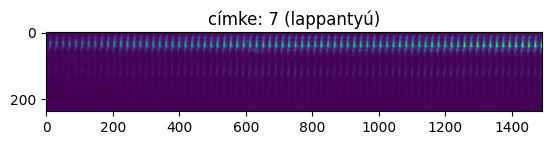

In [9]:
# (cella első futtatása ~20s, utána 1-2s)

# egy tanító batch mérete
print('Példa batch mérete:')
samples, labels = train.as_numpy_iterator().next()
print(f'spektrogram batch:   (batchsize, time axis, frequency axis, image channels) = {samples.shape}')
print(f'címke batch:         (batchsize,) = {labels.shape}\n')

# a példa batch 1. hangmintája és annak címkéje
i=0
print(f'Példa batch {i+1}. hangmintája:')
plt.imshow(np.transpose(samples[i], axes=(1,0,2)))
plt.title(f'címke: {labels[i]} ({label_dict[labels[i]]})');

### Model and training

A hangfelismeréses feladatot a spektrogramok segítségével képfelismerésként kezelhetjük. A képbeli mintázatok tanulásához alkossunk egy egyszerű modellt `model` néven a Tensorflow Sequential() API-ja segítségével, ami a következő felépítésű:

- a modell (1491, 237, 1) alakú képeket vár inputnak (batchekben)
- 3-szor megismétli az alábbi 2 réteget:
    - 2D konvolúció 16 db 3x3-as kernellel, ReLU aktivációval
    - (2, 2) alakú maxpooling
- az előző rétegből jövő (187, 27, 16) alakú tömböket 1D vektorrá lapítja
- fully connected layer következik 128 neuronnal és ReLU aktivációval
- egy záró fully connected layer következik 9 neuronnal (9 madárfaj)
- az aktivációt úgy válaszd meg, hogy a modell pszeudovalószínűségeket prediktáljon

A fent meg nem határozott paraméterek az alapértelmezettek. A megoldáshoz segítségül hívhatsz nyelvi modellt.

In [11]:
# szükséges importok
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D

In [14]:
# MODELLDEFINÍCIÓ CELLÁJA

model = Sequential()

model.add(Conv2D(16, (3,3), activation='relu', input_shape=(1491,237,1)))
model.add(MaxPooling2D(pool_size = (2,2)))

for _ in range(3):
  model.add(Conv2D(16, (3,3), activation='relu'))
  model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(9, activation='softmax'))
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 1489, 235, 16)     160       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 744, 117, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 742, 115, 16)      2320      
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 371, 57, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 369, 55, 16)       2320      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 184, 27, 16)      

In [15]:
# lefordítjuk a modellt Adam optimizerrel és a szokásos klasszifikációs lossal
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='SparseCategoricalCrossentropy', metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

Alább betanítjuk a modellt. A validációs categorical accuracy ennél a problémánál általában néhány epoch alatt 0.92 fölé nő.  
(Ha ez nem teljesül, futtassuk újra a cellákat a modelldefiniálástól.)

In [16]:
# modell tanítása early stoppinggal, legjobb súlyok visszaállítása
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=1, restore_best_weights=True)
hist = model.fit(train, epochs=4, validation_data=test, callbacks = [early_stopping])

Epoch 1/4
45/45 [==============================] - 22s 175ms/step - loss: 0.6969 - sparse_categorical_accuracy: 0.7694 - val_loss: 0.3484 - val_sparse_categorical_accuracy: 0.8728
Epoch 2/4
45/45 [==============================] - 3s 67ms/step - loss: 0.0917 - sparse_categorical_accuracy: 0.9778 - val_loss: 0.2283 - val_sparse_categorical_accuracy: 0.9191
Epoch 3/4
45/45 [==============================] - 3s 72ms/step - loss: 0.0086 - sparse_categorical_accuracy: 0.9986 - val_loss: 0.2261 - val_sparse_categorical_accuracy: 0.9191
Epoch 4/4
45/45 [==============================] - 3s 68ms/step - loss: 0.0065 - sparse_categorical_accuracy: 0.9972 - val_loss: 0.4455 - val_sparse_categorical_accuracy: 0.8728


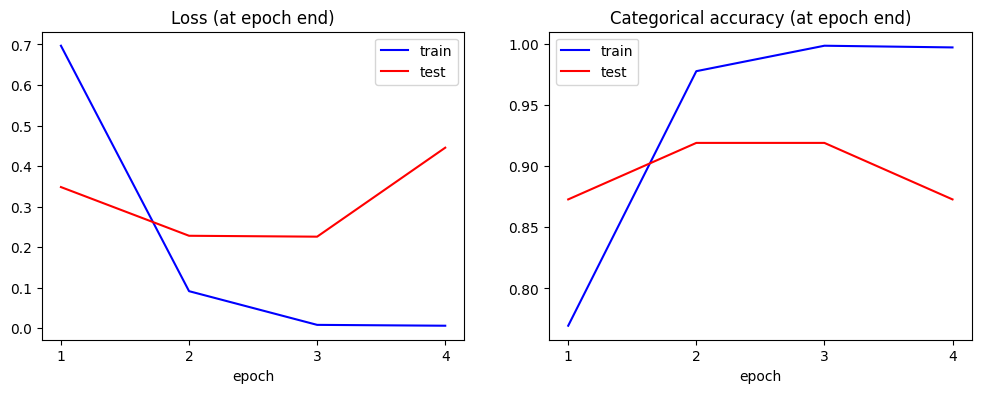

In [17]:
# tanulási folyamat szemléltetése
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
xticks = np.arange(len(hist.history))

ax1.set_title('Loss (at epoch end)')
ax1.plot(hist.history['loss'], 'b', label='train')
ax1.plot(hist.history['val_loss'], 'r', label='test')
ax1.set_xlabel('epoch')
ax1.set_xticks(xticks, xticks+1)
ax1.legend()

ax2.set_title('Categorical accuracy (at epoch end)')
ax2.plot(hist.history['sparse_categorical_accuracy'], 'b', label='train')
ax2.plot(hist.history['val_sparse_categorical_accuracy'], 'r', label='test')
ax2.set_xlabel('epoch')
ax2.set_xticks(xticks, xticks+1)
ax2.legend()

fig.show()

11/11 [==============================] - 1s 31ms/step


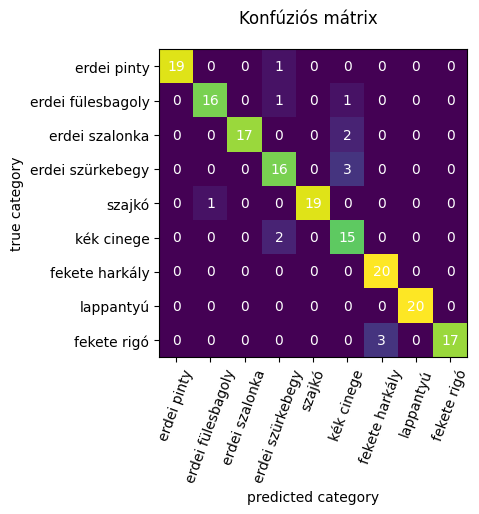

In [18]:
# Konfúziós mátrix: a modell kategóriánkénti eredményei a teszthalmazon

from sklearn.metrics import confusion_matrix

y_true_classes = list(test_window_summary['label'])  # ground truth címkék
y_pred = model.predict(test)  # prediktált pszeudovalószínűségek, melyekből...
y_pred_classes = np.argmax(y_pred, axis=1)  # ... prediktál címkék
conf_matrix = confusion_matrix(y_true = y_true_classes, y_pred = y_pred_classes)  # konfúziós mátrix

fig = plt.figure(figsize = (4,4))
fig.suptitle('Konfúziós mátrix')
ax = plt.subplot(1,1,1)
ax.imshow(conf_matrix)
ax.set_xticks(list(label_dict.keys()), list(label_dict.values()), rotation=70)
ax.set_yticks(list(label_dict.keys()), list(label_dict.values()))
for i in range(len(label_dict)):
    for j in range(len(label_dict)):
        text = ax.text(j, i, conf_matrix[i, j], ha="center", va="center", color="w")
ax.set_xlabel('predicted category')
ax.set_ylabel('true category')
fig.show()

## 2. rész: Prediktálás libahang-mintákra

<p align="center">
    <img src="https://i.ibb.co/BrXt004/lib-k.png" alt="libak", height=400>
</p>

### Hangminták kivágása ipywidget segítségével

A libapásztor felvételeit a `libáim_1.wav` és a `libáim_2.wav` fájl tartalmazza. Ebből ezúttal kézileg szeretnénk kivágni az összes olyan 3 másodperces szakaszt, ahol megszólalnak a libák. Ezt segíti, ha látjuk magunk előtt a spektrogramot, és lehetőség szerint interaktív módon kijelölhetjük a kivágandó szakaszt, amit meg is hallgathatunk. Ehhez alább definiálunk magunknak egy kis ipywidget eszközt. (Ez hasonló ahhoz, amivel az erdei madarak táblázatos időablakai lettek meghatározva.)

Tippek:
- A `t0` feliratú görgő segítségével a 3000 ms hosszú időablak kezdőpontját állíthatod be. Az aktuális érték a görgősávtól jobbra látható. A plot a görgő elengedésekor frissül.
- A `get_audio` gomb felhoz egy hanglejátszót az aktuális időablakhoz.
- A `zoom_window` egy megjelenítési beállítás, kinagyítja az időablakot.
- Ha kiválasztottad a kívánt időablakot, akkor a hozzá tartozó hangmintát a `Snapshot` gombbal kimentheted a `goose_sounds_cut` mappába. (A hangfájlból mentett minták információi kiíródnak a plot alatt.)
- Kattints a `Next` gombra, ha végeztél az első hangfájllal!

In [32]:
# eszköz hangminták kivágására

def process_soundfile(soundfile_path, use_denoised_logarithm = True, freq_cutoff = 20):
    # loading audio
    audio = AudioSegment.from_file(soundfile_path)
    amplitude = audio.get_array_of_samples()
    sample_rate = audio.frame_rate
    time = np.arange(len(amplitude))*1000/sample_rate  #ms

    # creating spectrogram
    spectrogram = tf.signal.stft(np.float32(amplitude), frame_length=320, frame_step=300).numpy()
    spectrogram = np.abs(spectrogram)
    if use_denoised_logarithm:
        spectrogram = spectrogram ** 0.7
        noisy_spectr = ((spectrogram/np.max(spectrogram)) * 255).astype(np.uint8)
        spectrogram = noisy_spectr
    if freq_cutoff is not None:
        spectrogram = spectrogram[:, freq_cutoff:]

    # getting x1-coordinates (time [1 ms]) and x2-coordinates (frequency [1 λ·Hz]) for the spectrogram
    len_t, len_f = spectrogram.shape
    x1s = np.linspace(time[0], time[-1], len_t)
    x2s = np.arange(freq_cutoff, len_f+freq_cutoff)

    return audio, x1s, x2s, spectrogram


def get_next(button):
    global soundfile_iterator, window_snapshots, soundfile, audio
    soundfile = next(soundfile_iterator)
    while soundfile in window_snapshots.keys():
        soundfile = next(soundfile_iterator)

    clear_output()
    print(f'Recording: {soundfile}')
    button.description = 'Next'
    display(buttons_container)

    # create spectrogram from audio file
    soundfile_path = os.path.join('/content/', soundfile)
    audio, x1s, x2s, spectrogram = process_soundfile(soundfile_path, use_denoised_logarithm = True, freq_cutoff = 20)

    # plot spectrogram
    partial_func_for_interact = lambda t0,get_audio,zoom_window: plot_spectrogram(x1s, x2s, spectrogram, audio, t0=t0, get_audio=get_audio, zoom_window=zoom_window)
    int_slider = widgets.IntSlider(value=0, min=0, max=x1s[-1], step=100, layout=widgets.Layout(width='100%'), continuous_update=False)
    interact(partial_func_for_interact, t0=int_slider, get_audio=False, zoom_window=False)

    print(f'{soundfile} snapshots created:')


def create_snapshot_for_window(button):
    global window_snapshots, soundfile, audio, time_start, time_end
    audio_cut = audio[time_start : time_end]
    audio_cut = audio_cut.set_sample_width(2) # 2 bytes -> 16-bit WAV file
    cut_name = f'liba_{len(sum(window_snapshots.values(), [])) + 1}.wav'
    audio_cut.export(os.path.join('goose_sounds_cut', cut_name), format='wav')
    window_snapshots[soundfile] = window_snapshots.get(soundfile, [])
    window_snapshots[soundfile].append((time_start, time_end))
    print(f'{window_snapshots[soundfile][-1]}  -->  {cut_name}')


def plot_spectrogram(x1s, x2s, spectrogram, audio, t0=0, get_audio=False, zoom_window=False):
    global time_start, time_end
    time_start = t0
    time_end = time_start + 3000  # 3s window

    if zoom_window:
        x1s_zoom = (time_start <= x1s) & (x1s <= time_end)
        x1s = x1s[x1s_zoom]
        spectrogram = spectrogram[x1s_zoom, :]
    else:
        x1s = x1s[::3]
        x2s = x2s[::3]
        spectrogram = spectrogram[::3, ::3]
    fig, ax = plt.subplots(1, 1, figsize=(15,5))
    plt.tight_layout()
    grid_x1s, grid_x2s = np.meshgrid(x1s, x2s)
    ax.pcolormesh(grid_x1s, grid_x2s, np.transpose(spectrogram))
    ax.axvline(x=time_start, color='red')
    ax.axvline(x=time_end, color='red')
    ax.set_xlabel('time [ms]')
    if zoom_window:
        ax.set_xlim(time_start, time_end)
    else:
        ax.set_xlim(x1s[0]-100,x1s[-1])

    if get_audio:
        display(audio[time_start:time_end]) #ms
    plt.show()

shutil.rmtree('/content/goose_sounds_cut', ignore_errors=True)
os.makedirs('/content/goose_sounds_cut')
soundfile_iterator = iter(['libáim_1.wav', 'libáim_2.wav'])
window_snapshots = {}
next_button = widgets.Button(description='Next')
next_button.on_click(get_next)
snapshot_button = widgets.Button(description='Snapshot')
snapshot_button.on_click(create_snapshot_for_window)
buttons_container = widgets.HBox([next_button, snapshot_button])

get_next(next_button)

Recording: libáim_1.wav


interactive(children=(IntSlider(value=0, continuous_update=False, description='t0', layout=Layout(width='100%'…

libáim_1.wav snapshots created:
(3100, 6100)  -->  liba_1.wav


### Dataloader és predikciók libahangokra

A madárhangok teszthalmazának betöltőjét alapul véve készíts egy olyan dataloader-t `test_goose` néven, ami a `goose_sounds_cut` mappában szereplő libahangokat felhasználva generál input-címke párokat a modell számára.

Tippek:
- A `paths` változóba kerülő útvonalak összerakásához a fájlnevek kigyűjthetők az `os.listdir('goose_sounds_cut')` segítségével.
- Mivel ezúttal csak prediktálni fogunk, így a `labels_tf` dataset-ben tetszőleges címkéket elhelyezhetsz, amíg a darabszámuk megegyezik a hangminták számával.

In [30]:
# LIBA INPUT-CÍMKE PÁROK BETÖLTŐJE


paths_tf = tf.data.Dataset.from_tensor_slices(paths)  # hangfájlok útvonalai dataset
labels_tf = tf.data.Dataset.from_tensor_slices(test_window_summary['label'])


sound_dir = 'goose_sounds_cut'
sound_files = [os.path.join(sound_dir, file) for file in os.listdir(sound_dir) if file.endswith('.wav')]


dataset = tf.data.Dataset.from_tensor_slices((sound_files))
labels_tf = tf.data.Dataset.from_tensor_slices([1, 1, 1, 1, 1, 1, 1])

test_goose = tf.data.Dataset.zip((paths_tf, labels_tf))  # útvonalak és címkék összepárosítása
test_goose = test_goose.map(preprocess)  # az útvonalak hangfájljaiból adatgeneráláskor spektrogramot állítunk elő
test_goose = test_goose.cache()
test_goose = test_goose.batch(16, drop_remainder=False)  # 16 méretű batchekben adagoljuk az input-címke párokat
test_goose = test_goose.prefetch(16)


In [31]:
# prediktálás a liba inputra

y_pred = model.predict(test_goose)
y_pred_classes = np.argmax(y_pred, axis = 1)

print('\nPrediktált madár:\n')
for idx in y_pred_classes:
    print(label_dict[idx])

1/1 [==============================] - 1s 653ms/step

Prediktált madár:

erdei pinty
erdei pinty
erdei pinty
erdei pinty
erdei pinty
erdei pinty
erdei pinty
